# Long Analysis: Single run 
Plots for the long-term performance temporal mean-Bias, zonal mean, spectra, zonal EOFs and PC autocorrelations, divergence, PDF, and return periods

In [ ]:
import sys
sys.path.append('..')

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

from inference.utils.long_metrics import return_period_bins, corr_truth_train_model

In [2]:
Lx, Ly = 2 * np.pi, 2 * np.pi
Nx, Ny = 256, 256
target_step = 3

In [13]:

train_analysis_dir = '/glade/derecho/scratch/dpatel/SSL-2DTurb/BASE/BASE_seed_0_2phase_1000epochs/analysis/train'
truth_analysis_dir = '/glade/derecho/scratch/dpatel/SSL-2DTurb/TRUTH/IC1/analysis/truth'
base_analysis_dir = '/glade/derecho/scratch/jshen/base/long_analyses'

analysis_dirs = [
    truth_analysis_dir, train_analysis_dir
]
plt_kwargs = [
    {'color': 'k', 'linestyle': '--', 'label': 'Truth'}, 
    {'color': 'r', 'linestyle': '--', 'label': 'Train'}
]

emulator_analysis_tuples = [(0, base_analysis_dir)]
emulator_dir = '/glade/derecho/scratch/jshen/prune_base/attention_heads/long_analyses'
for dirname in os.listdir(emulator_dir):
    
    try:
        percentage = 100 - float(dirname)
    except: continue

    #if dirname != '25': continue

    analyses_dir = os.path.join(emulator_dir, dirname)
    if not os.path.isdir(analyses_dir): continue
    if not os.path.isfile(os.path.join(analyses_dir, 'div.npy')): continue
    if not os.path.isfile(os.path.join(analyses_dir, 'zonal_mean.npz')): continue
    if not os.path.isfile(os.path.join(analyses_dir, 'spectra.npz')): continue
    if not os.path.isfile(os.path.join(analyses_dir, 'extremes.npz')): continue

    print(dirname)

    emulator_analysis_tuples.append((percentage, analyses_dir))

emulator_analysis_tuples = sorted(emulator_analysis_tuples, key=lambda x: x[0])

percentages, emulator_analysis_dirs = zip(*emulator_analysis_tuples)
analysis_dirs += emulator_analysis_dirs

norm = mcolors.Normalize(vmin=min(percentages), vmax=max(percentages))
plt_kwargs += [
    {'color': plt.cm.viridis(norm(p)), 'label': f"{p:.1f}%"} 
    for p in percentages
]

18
20


# Spectra

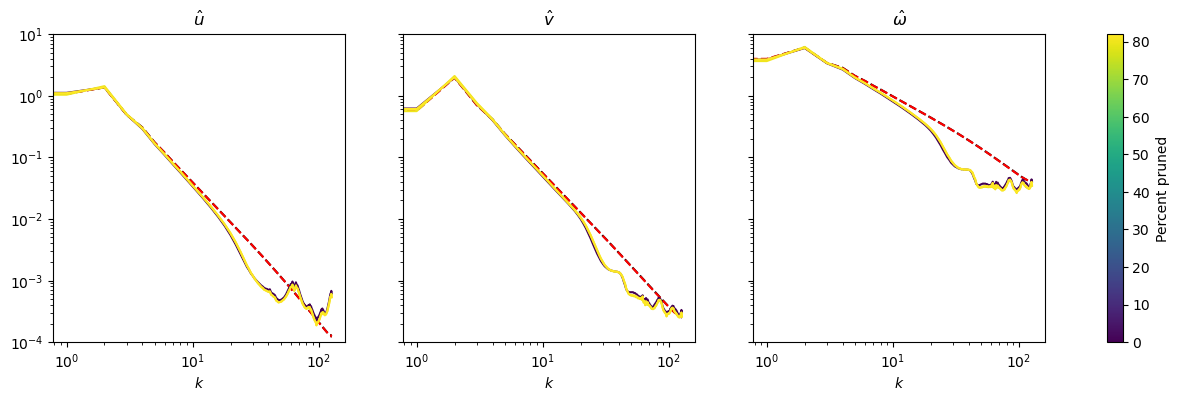

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)  # Adjust figure size as needed

for kwargs, analysis_dir in zip(plt_kwargs, analysis_dirs):

    data = np.load(os.path.join(analysis_dir, "spectra.npz"))

    U_spectra = data['spectra_U_zonal_avg']
    V_spectra = data['spectra_V_zonal_avg']
    Omega_spectra = data['spectra_Omega_zonal_avg']
    wavenumbers = data['wavenumber_zonal_avg']

    axes[0].loglog(wavenumbers[:-1], U_spectra[:-1], **kwargs)
    axes[1].loglog(wavenumbers[:-1], V_spectra[:-1], **kwargs)
    axes[2].loglog(wavenumbers[:-1], Omega_spectra[:-1], **kwargs)

for ax in axes.flatten():
    ax.set_xlabel('$k$')
    ax.set_ylim([1e-4, 10])

axes[0].set_title('$\hat{u}$', rotation=0)
axes[1].set_title('$\hat{v}$', rotation=0)
axes[2].set_title('$\hat{\omega}$', rotation=0)

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=axes, location='right', label="Percent pruned", pad=0.05)

# Zonal Mean

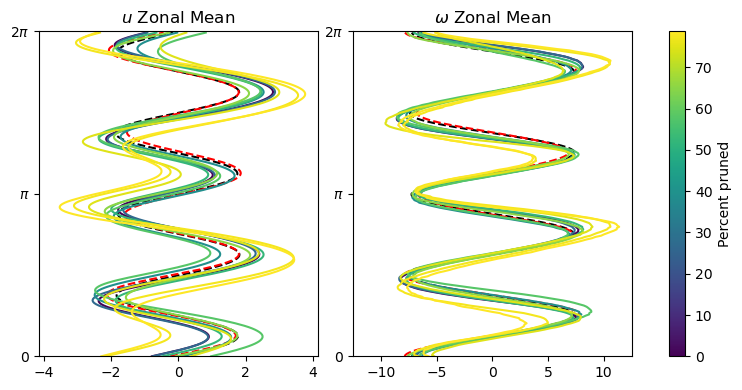

In [5]:
fig, axes = plt.subplots(1,2,figsize=(8, 4), layout="compressed")  # Adjust figure size as needed

dx = Lx/Nx
y = np.linspace(0,2*np.pi-dx,Nx)

for kwargs, analysis_dir in zip(plt_kwargs, analysis_dirs):

    data = np.load(analysis_dir + "/zonal_mean.npz")

    U_mean_zonal = data['U_zonal_mean']
    Omega_mean_zonal = data['Omega_zonal_mean']

    axes[0].plot(U_mean_zonal, y, **kwargs)
    axes[1].plot(Omega_mean_zonal, y, **kwargs)

    if analysis_dir == truth_analysis_dir:
        U_zonal_mean_truth = U_mean_zonal
        Omega_zonal_mean_truth = Omega_mean_zonal
    elif analysis_dir == train_analysis_dir:
        U_zonal_mean_train = U_mean_zonal
        Omega_zonal_mean_train = Omega_mean_zonal
    else:
        U_zonal_mean_emulator = U_mean_zonal
        Omega_zonal_mean_emulator = Omega_mean_zonal

axes[0].set_title(r'$u$ Zonal Mean')
axes[1].set_title(r'$\omega$ Zonal Mean')

for ax in axes.flatten():
    ax.set_yticks([0, np.pi, 2*np.pi])
    ax.set_yticklabels(['0', r'$\pi$', r'$2\pi$'])
    ax.set_ylim([0, 2*np.pi])
U_mean_zonal_max = np.max(np.abs([U_zonal_mean_truth, U_zonal_mean_train, U_zonal_mean_emulator]))
Omega_mean_zonal_max = np.max(np.abs([Omega_zonal_mean_truth, Omega_zonal_mean_train, Omega_zonal_mean_emulator]))

axes[0].set_xlim([-1.1*U_mean_zonal_max, 1.1*U_mean_zonal_max])
axes[1].set_xlim([-1.1*Omega_mean_zonal_max, 1.1*Omega_mean_zonal_max])

fig.tight_layout()

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=axes, location='right', label="Percent pruned", pad=0.05)


# Temporal Mean

In [ ]:
################### Sample Mean ###################

from inference.utils.plot_config import contourLevels, colormap

temp_dirs = [
    truth_analysis_dir, 
    train_analysis_dir,  
    '/glade/derecho/scratch/jshen/prune_base/l1/long_analyses/42', 
]

fig, axes = plt.subplots(3, 3, figsize=(8, 8), layout='constrained')
for i, (label, analysis_dir) in enumerate(zip(['Truth', 'Train', 'Emulator'], temp_dirs)):

    data = np.load(analysis_dir + "/temporal_mean.npz")
    # data = np.load(analysis_dir_truth + "/temporal_mean.npz")

    U_mean_sample = data['U_sample_mean']
    V_mean_sample = data['V_sample_mean']
    Omega_mean_sample = data['Omega_sample_mean']

    if i == 0:
        vmax_U = np.max(U_mean_sample)
        vmax_V = np.max(V_mean_sample)
        vmax_Omega = np.max(Omega_mean_sample)

    axes[0,i].contourf(U_mean_sample, levels=contourLevels, cmap=colormap, vmax=vmax_U, vmin=-vmax_U)
    axes[1,i].contourf(V_mean_sample, levels=contourLevels, cmap=colormap, vmax=vmax_V, vmin=-vmax_V)
    axes[2,i].contourf(Omega_mean_sample, levels=contourLevels, cmap=colormap, vmax=vmax_Omega, vmin=-vmax_Omega)

    axes[0,i].set_title(rf"$u$ {label}")
    axes[1,i].set_title(rf"$v$ {label}")
    axes[2,i].set_title(rf"$\omega$ {label}")

# Set aspect ratio to equal and remove labels for all axes
for ax in axes.flat:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle(r'Temporal Mean')

# Bias: Temporal Mean

In [7]:
# ################### Sample Mean Difference ###################


# for i, analysis_dir in enumerate(analysis_dir_arr):

#     data = np.load(analysis_dir + "/temporal_mean.npz")
#     # data = np.load(analysis_dir_truth + "/temporal_mean.npz")

#     if analysis_dir == truth_analyses_dir:

#         U_mean_sample_truth = data['U_sample_mean']
#         V_mean_sample_truth = data['V_sample_mean']
#         Omega_mean_sample_truth = data['Omega_sample_mean']

#     elif analysis_dir == train_analyses_dir:

#         U_mean_sample_train = data['U_sample_mean']
#         V_mean_sample_train = data['V_sample_mean']
#         Omega_mean_sample_train = data['Omega_sample_mean']

#     elif analysis_dir == emulator_analyses_dir:

#         U_mean_sample_emulator = data['U_sample_mean']
#         V_mean_sample_emulator = data['V_sample_mean']
#         Omega_mean_sample_emulator = data['Omega_sample_mean']

#     # if i == 0:
# vmax_U = np.max(U_mean_sample_truth)
# vmax_V = np.max(V_mean_sample_truth)
# vmax_Omega = np.max(Omega_mean_sample_truth)

# fig, axes = plt.subplots(3, 3, figsize=(8, 8), layout='constrained')
# plt.rcParams.update(params)


# axes[0,0].contourf(U_mean_sample_truth-U_mean_sample_train, levels=contourLevels, cmap=colormap, vmax=vmax_U, vmin=-vmax_U)
# axes[1,0].contourf(V_mean_sample_truth-V_mean_sample_train, levels=contourLevels, cmap=colormap, vmax=vmax_V, vmin=-vmax_V)
# axes[2,0].contourf(Omega_mean_sample_truth-Omega_mean_sample_train, levels=contourLevels, cmap=colormap, vmax=vmax_Omega, vmin=-vmax_Omega)

# axes[0,1].contourf(U_mean_sample_truth-U_mean_sample_emulator, levels=contourLevels, cmap=colormap, vmax=vmax_U, vmin=-vmax_U)
# axes[1,1].contourf(V_mean_sample_truth-V_mean_sample_emulator, levels=contourLevels, cmap=colormap, vmax=vmax_V, vmin=-vmax_V)
# axes[2,1].contourf(Omega_mean_sample_truth-Omega_mean_sample_emulator, levels=contourLevels, cmap=colormap, vmax=vmax_Omega, vmin=-vmax_Omega)

# axes[0,2].contourf(U_mean_sample_train-U_mean_sample_emulator, levels=contourLevels, cmap=colormap, vmax=vmax_U, vmin=-vmax_U)
# axes[1,2].contourf(V_mean_sample_train-V_mean_sample_emulator, levels=contourLevels, cmap=colormap, vmax=vmax_V, vmin=-vmax_V)
# axes[2,2].contourf(Omega_mean_sample_train-Omega_mean_sample_emulator, levels=contourLevels, cmap=colormap, vmax=vmax_Omega, vmin=-vmax_Omega)


# fig.suptitle(r'Bias: Temporal Mean')
# axes[0,0].set_title(r'$u$ Truth - $u$ Train')
# axes[0,1].set_title(r'$u$ Truth - $u$ Emulator')
# axes[0,2].set_title(r'$u$ Train - $u$ Emulator')

# axes[1,0].set_title(r'$v$ Truth - $v$ Train')
# axes[1,1].set_title(r'$v$ Truth - $v$ Emulator')
# axes[1,2].set_title(r'$v$ Train - $v$ Emulator')

# axes[2,0].set_title(r'$\omega$ Truth - $\omega$ Train')
# axes[2,1].set_title(r'$\omega$ Truth - $\omega$ Emulator')
# axes[2,2].set_title(r'$\omega$ Train - $\omega$ Emulator')

# for ax in axes.flatten():
#     ax.set_aspect('equal', 'box')
#     ax.set_xticks([])
#     ax.set_yticks([])

# print('Sample Mean Correlations')
# print('Correlation: (Truth, Train), (Truth, Emulator), (Train, Emulator)')
# print('Corr U     :', corr_truth_train_model(U_mean_sample_truth, U_mean_sample_train, U_mean_sample_emulator))
# print('Corr Omega :', corr_truth_train_model(Omega_mean_sample_truth, Omega_mean_sample_train, Omega_mean_sample_emulator))
# print('Corr V     :', corr_truth_train_model(V_mean_sample_truth, V_mean_sample_train, V_mean_sample_emulator))


## EOF

In [8]:
# ################### EOF ###################

# fig, axes = plt.subplots(1,2,figsize=(8, 4), layout="compressed")  # Adjust figure size as needed
# plt.rcParams.update(params)


# for i, analysis_dir in enumerate(analysis_dir_arr):

#     data = np.load(analysis_dir + "/zonal_eof_pc.npz", allow_pickle=True)

#     EOF_U = data["U_eofs"]
#     if EOF_U.shape[0] != Ny:
#         EOF_U = EOF_U.T
#     exp_var_U = data["U_expvar"] # percent
#     print(f'EOF_U.shape: {EOF_U.shape}')

#     # EOF_Omega = data["Omega_eofs"]
#     # if EOF_Omega.shape[0] != Ny:
#     #     EOF_Omega = EOF_Omega.T
#     # EOF_Omega = data["Omega_eofs"]
#     # exp_var_Omega = data["Omega_expvar"] # percent

#     exp_var_U = 100*np.round(exp_var_U, 3)
#     # exp_var_Omega = 100*np.round(exp_var_Omega, 3)

#     #print(exp_var_Omega)

#     y = np.linspace(0, Lx, Ny)

#     for count in range(2):
#         if (i ==2 and count == 0) or (i == 1 and count == 1):
#             EOF_U = -1 * EOF_U
#         axes[count].plot(EOF_U[:,count], y, colors[i], label=f'{exp_var_U[count]:.2f}%')
#         # axes[1,count].plot(EOF_Omega[:,count], y, colors[i], label=f'{exp_var_Omega[count]}%')

# for ax in axes.flatten():
#     ax.set_yticks([0, np.pi, 2*np.pi])
#     ax.set_yticklabels(['0', r'$\pi$', r'$2\pi$'])
#     ax.set_ylim([0, 2*np.pi])


# for count in range(2):
#     axes[count].set_title(rf'$u$ EOF {count+1}')
#     EOF_max = np.max(np.abs([EOF_U[:,count]]))
#     axes[count].set_xlim([-1.4*EOF_max, 1.4*EOF_max])
#     axes[count].legend(frameon=False)

#     # axes[1,count].set_title(rf'$\omega$ EOF{count+1}')
#     # EOF_max = np.max(np.abs([EOF_Omega[:,count]]))
#     # axes[1,count].set_xlim([-1.4*EOF_max, 1.4*EOF_max])
#     # axes[1,count].legend(frameon=False)

# plt.show()


In [9]:
# fig, axes = plt.subplots(1, 2, figsize=(8, 4), layout='constrained')
# plt.rcParams.update(params)

# for i, analysis_dir in enumerate(analysis_dir_arr):

#     data = np.load(analysis_dir + "/zonal_eof_pc.npz", allow_pickle=True)

#     PC_acf_U = data["U_pc_acf"]
#     PC_acf_Omega = data["Omega_pc_acf"]

#     for count in range(2):

#         acf_U = PC_acf_U[count]
#         acf_Omega = PC_acf_Omega[count]

#         acf_U = PC_acf_U[count]
#         acf_Omega = PC_acf_Omega[count]

#         # Training data and emulation data are saved at different time steps
#         if analysis_dir == emulator_analyses_dir or analysis_dir == truth_analyses_dir:
#             time = np.linspace(0, acf_U['acf'].shape[0], acf_U['acf'].shape[0])
#         else:
#             time = np.linspace(0, acf_U['acf'].shape[0]/target_step, acf_U['acf'].shape[0])

#         axes[count].plot(time, acf_U['acf'], colors[i], label=label[i])
#         axes[count].fill_between(time, acf_U['confint'][:,0], acf_U['confint'][:,1], color=color[i], alpha=0.2)

#         #axes[1,count].plot(time, acf_Omega['acf'], colors[i], label=label[i])
#         #axes[1,count].fill_between(time, acf_Omega['confint'][:,0], acf_Omega['confint'][:,1], color=color[i], alpha=0.2)
        
#         axes[count].set_title(rf'$u$ EOF {count+1} ACF')
#         #axes[1,count].set_title(rf'$\omega$ PC{count+1} ACF')

#         axes[count].set_xlabel('$\Delta t$')
#         axes[count].set_ylim([0, 1])
#         axes[count].set_xlim([0, 300])

# axes[0].legend(frameon=False)
# #axes[1,0].legend(frameon=False)

#     # axes[0,0].legend()
#     # axes[1,0].legend()


# Divergence

Text(0, 0.5, '$ \\langle |\\nabla \\cdot u |\\rangle$')

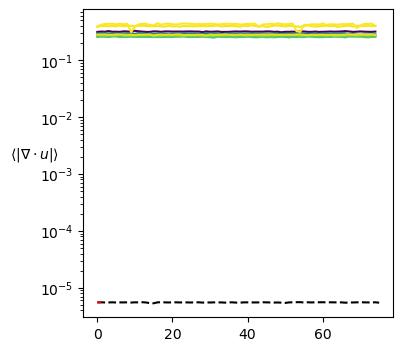

In [10]:
fig, axes = plt.subplots(1, figsize=(4, 4))

for kwargs, analysis_dir in zip(plt_kwargs, analysis_dirs):

    div = np.load(analysis_dir + "/div.npy")

    mean_div = []
    for i in range(0, div.shape[0], 10000):
        mean_div.append(div[i:i+10000].mean())

    axes.semilogy(mean_div, **kwargs)

axes.set_ylabel(r'$ \langle |\nabla \cdot u |\rangle$', rotation=0)

Text(0.5, 1.0, 'Mean divergence over 750k timesteps')

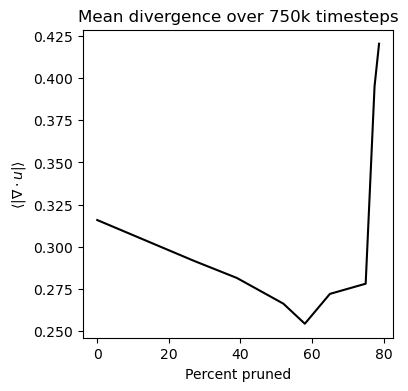

In [11]:
fig, ax = plt.subplots(1, figsize=(4, 4))

sorted_indices = np.argsort(percentages)
divs = np.array([np.load(analysis_dir + "/div.npy").mean() for analysis_dir in analysis_dirs[2:]])

ax.plot(
    np.array(percentages)[sorted_indices],
    divs[sorted_indices], 
    color='black'
)
ax.set_xlabel('Percent pruned')
ax.set_ylabel(r'$ \langle |\nabla \cdot u |\rangle$')
ax.set_title('Mean divergence over 750k timesteps')


## Return Period

NameError: name 'train_analyses_dir' is not defined

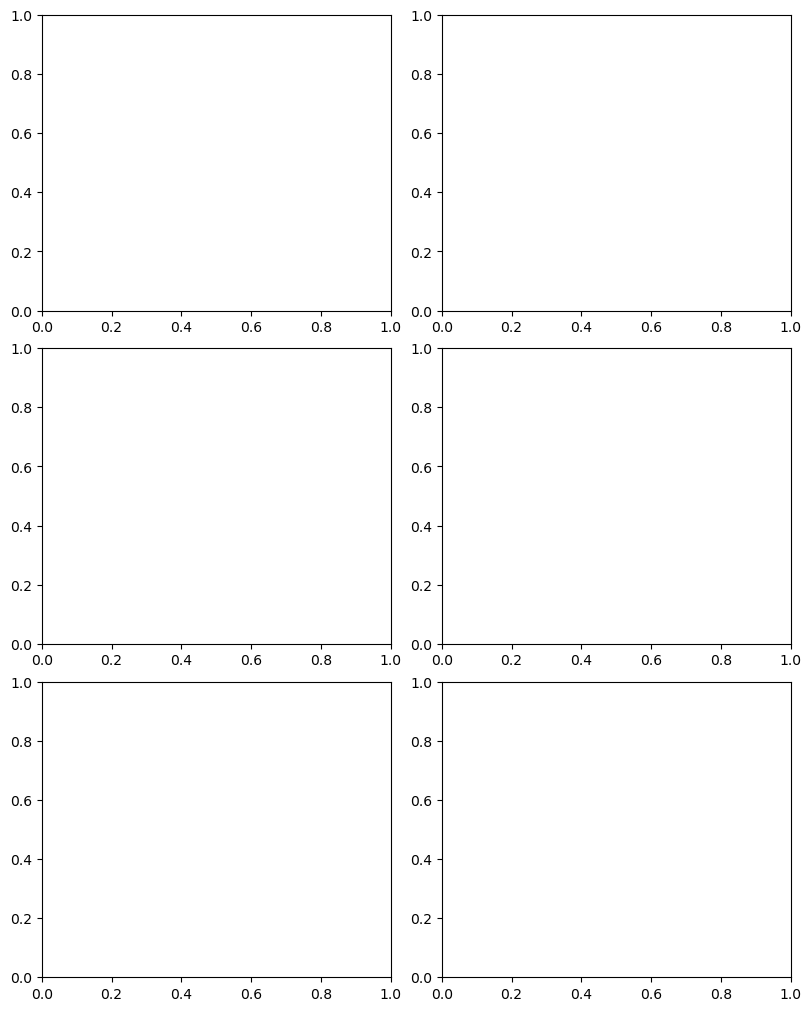

In [12]:
dt_data = 0.06
markersize = 3
U_std = 2.34
V_std = 1.88
Omega_std = 10.41
bins = 100

# for return_period_type in ['extremes', 'extremes_anom']:
for return_period_type in ['extremes']:

    fig, axes = plt.subplots(3, 2, figsize=(8, 10), layout='constrained')

    for kwargs, analysis_dir in zip(plt_kwargs, analysis_dirs):

        data = np.load(os.path.join(analysis_dir, f"{return_period_type}.npz"))

        U_max = data["U_max_arr"]/U_std
        V_max = data["V_max_arr"]/V_std
        Omega_max = data["Omega_max_arr"]/Omega_std

        U_min = data["U_min_arr"]/U_std
        V_min = data["V_min_arr"]/V_std
        Omega_min = data["Omega_min_arr"]/Omega_std

        if analysis_dir == train_analyses_dir:
            U_max = U_max[::3]
            V_max = V_max[::3]
            Omega_max = Omega_max[::3]
            U_min = U_min[::3]
            V_min = V_min[::3]
            Omega_min = Omega_min[::3]

        if analysis_dir == train_analyses_dir:
            dt = dt_data / 3
        else:
            dt = dt_data

        # Binning the data to calculate return periods; Plotting thousands of points can be slow
        # Use return_period_empirical function to calculate return periods without binning
        # e.g: U_max_return_period, U_amplitude_max = return_period_empirical(U_max, dt=dt)

        U_max_return_period, U_amplitude_max = return_period_bins(U_max, dt=dt, bins_num=bins)
        V_max_return_period, V_amplitude_max = return_period_bins(V_max, dt=dt, bins_num=bins)
        Omega_max_return_period, Omega_amplitude_max = return_period_bins(Omega_max, dt=dt, bins_num=bins)
        U_min_return_period, U_amplitude_min = return_period_bins(np.abs(U_min), dt=dt, bins_num=bins)
        V_min_return_period, V_amplitude_min = return_period_bins(np.abs(V_min), dt=dt, bins_num=bins)
        Omega_min_return_period, Omega_amplitude_min = return_period_bins(np.abs(Omega_min), dt=dt, bins_num=bins)

        axes[0,0].semilogy(-U_amplitude_min, U_min_return_period, **kwargs)
        axes[0,1].semilogy(U_amplitude_max, U_max_return_period, **kwargs)
        axes[1,0].semilogy(-V_amplitude_min, V_min_return_period, **kwargs)
        axes[1,1].semilogy(V_amplitude_max, V_max_return_period, **kwargs)
        axes[2,0].semilogy(-Omega_amplitude_min, Omega_min_return_period, **kwargs)
        axes[2,1].semilogy(Omega_amplitude_max, Omega_max_return_period, **kwargs)

        axes[0,0].set_ylabel('Return period')
        axes[1,0].set_ylabel('Return period')
        axes[2,0].set_ylabel('Return period')

        if return_period_type == 'extremes':
            axes[0,0].set_xlabel(r'$u_{min}/\sigma_u$')
            axes[0,1].set_xlabel(r'$u_{max}/\sigma_u$')
            axes[1,0].set_xlabel(r'$v_{min}/\sigma_v$')
            axes[1,1].set_xlabel(r'$v_{max}/\sigma_v$')
            axes[2,0].set_xlabel(r'$\omega_{min}/\sigma_{\omega}$')
            axes[2,1].set_xlabel(r'$\omega_{max}/\sigma_{\omega}$')

        elif return_period_type == 'extremes_anom':
            axes[0,0].set_xlabel(r'$\left(u-\langle u\rangle\right)_{min}/\sigma_u$')
            axes[0,1].set_xlabel(r'$\left(u-\langle u\rangle\right)_{max}/\sigma_u$')
            axes[1,0].set_xlabel(r'$\left(v-\langle v\rangle\right)_{min}/\sigma_v$')
            axes[1,1].set_xlabel(r'$\left(v-\langle v\rangle\right)_{max}/\sigma_v$')
            axes[2,0].set_xlabel(r'$\left(\omega-\langle \omega\rangle\right)_{min}/\sigma_{\omega}$')
            axes[2,1].set_xlabel(r'$\left(\omega-\langle \omega\rangle\right)_{max}/\sigma_{\omega}$')

    # Use custom legend handles with dashed lines instead of marker symbols
    # custom_lines = [
    #     Line2D([0], [0], color=color[0], marker='o', lw=2, label=label[0]),
    #     Line2D([0], [0], color=color[1], marker='o', lw=2, label=label[1]),
    #     Line2D([0], [0], color=color[2], marker='o', lw=2, label=label[2]), 
    #     Line2D([0], [0], color=color[3], marker='o', lw=2, label=label[3])
    # ]
    # axes[0,0].legend(handles=custom_lines, frameon=False)

    # Save figure with different filenames for anom True/False

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=axes, location='bottom', label="Percent pruned", pad=0.05)


# PDF

In [ ]:
# fig, axes = plt.subplots(1,2,figsize=(8, 3.5), layout="compressed")  # Adjust figure size as needed
# plt.rcParams.update(params)

# for i, analysis_dir in enumerate(analysis_dir_arr):

#     data_U = np.load(analysis_dir + "/PDF_U.npz")
#     data_Omega = np.load(analysis_dir + "/PDF_Omega.npz")

#     U_pdf = data_U['U_pdf']
#     U_bins = data_U['U_bins']
#     U_std = data_U['U_std']
#     Omega_pdf = data_Omega['Omega_pdf']
#     Omega_bins = data_Omega['Omega_bins']
#     Omega_std = data_Omega['Omega_std']

#     axes[0].semilogy(U_bins/U_std, U_pdf, colors[i], label=label[i])
#     axes[1].semilogy(Omega_bins/Omega_std, Omega_pdf, colors[i], label=label[i])

# axes[0].set_title(r'$u$ PDF')
# axes[1].set_title(r'$\omega$ PDF')

# plt.legend(frameon=False)

# for ax in axes.flatten():
#     ax.set_xlabel('$k$')
#     ax.set_ylim([1e-7, 1])
#     ax.set_xlim([-5, 5])

# axes[0].set_xlabel(r'$u/\sigma_u$')
# axes[1].set_xlabel(r'$\omega/\sigma_{\omega}$')

# plt.legend(frameon=False)